LinkedIn Profile https://in.linkedin.com/in/jafar-ali-habshee-97242949

## Please Run all the cells below before starting with model building

## Authenticate using your gmail id
### Run the below cell. After running the cell one link will appear -> Click on Link -> login using your gmail id ->copy the code -> paste it in the box -> done

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Counting no. of rows in a table
### Sample Code

In [2]:
%%bigquery --project bq-storage-flask-app df
SELECT 
  COUNT(*) as total_rows
FROM `bigquery-public-data.stackoverflow.posts_questions`

,total_rows
0,17278709


## Setting up project Id globally

In [0]:
project_id = 'bq-storage-flask-app'

## Selecting approximately 2000 random rows from question dataset


In [4]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

sample_count = 2000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.stackoverflow.posts_questions`''').to_dataframe().total[0]

df_questions = client.query('''
  SELECT
    *
  FROM
   `bigquery-public-data.stackoverflow.posts_questions`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

#print('Full dataset has %d rows' % row_count)
df_questions.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,post_type_id,score,tags,view_count
0,41819735,What is the difference between SessionBundlePr...,"<p>As I read in the source code, <code>Session...",NaN,1,0,NaT,2017-01-24 03:54:00.183000+00:00,NaN,2017-09-08 15:16:47.183000+00:00,2017-07-06 01:14:33.033000+00:00,,5685754.0,,5685754.0,1,0,tensorflow-serving,59
1,29097225,Can I chain @BindBean params?,<p><code>@BindBean</code> allows me to use pro...,NaN,0,2,NaT,2015-03-17 10:52:23.657000+00:00,1.0,2015-03-17 10:52:23.657000+00:00,NaT,,NaN,,716027.0,1,2,java|jdbc|jdbi,101
2,53333415,Algorithm that increases randomness?,<p>Suppose i provide you with <strong>random s...,53340582.0,3,1,NaT,2018-11-16 07:41:46.897000+00:00,NaN,2018-11-16 15:35:06.027000+00:00,NaT,,NaN,,7946599.0,1,-3,random,39
3,12997742,Java Swing: Implementing a validity check of i...,"<p>In my Swing application, the user must inse...",12997850.0,4,0,NaT,2012-10-21 12:19:34+00:00,4.0,2014-04-02 18:07:54.243000+00:00,2014-04-02 18:07:54.243000+00:00,,125389.0,,1339620.0,1,8,java|swing|input,12644
4,22225349,NServiceBus handler turning up with empty mess...,"<p>I got a issue with NServiceBus 4.4.2, which...",22300390.0,2,3,NaT,2014-03-06 13:01:56.297000+00:00,1.0,2014-03-10 12:40:10.303000+00:00,NaT,,NaN,,3058441.0,1,3,c#|xml|json|nservicebus,901


## Selecting approximately 2000 random rows from answer dataset

In [5]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

sample_count = 2000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.stackoverflow.posts_answers`''').to_dataframe().total[0]

df_answers = client.query('''
  SELECT
    *
  FROM
    `bigquery-public-data.stackoverflow.posts_answers`
  WHERE RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()

df_answers.head()

,id,body,comment_count,community_owned_date,creation_date,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags
0,13151607,<p>How about appending a span element to the c...,1,NaT,2012-10-31 05:11:08.630000+00:00,2012-10-31 05:16:37.090000+00:00,2012-10-31 05:16:37.090000+00:00,,168762.0,,168762.0,128342,2,-1,
1,17634259,<p>You can get that attribute with the followi...,8,NaT,2013-07-13 21:10:45.330000+00:00,2013-07-13 22:48:36.423000+00:00,2013-07-13 22:48:36.423000+00:00,,1614607.0,,1614607.0,17634126,2,2,
2,52271998,<p>First you have to define the context of the...,0,NaT,2018-09-11 08:41:31.163000+00:00,2018-09-11 08:41:31.163000+00:00,NaT,,NaN,,10346328.0,49750811,2,1,
3,22926901,"<p>In jQuery Mobile, a class gets applied to t...",2,NaT,2014-04-08 03:19:52.970000+00:00,2014-04-08 03:19:52.970000+00:00,NaT,,NaN,,3494680.0,22926840,2,8,
4,39002547,<p>You are trying to reference an object that ...,0,NaT,2016-08-17 17:07:37.650000+00:00,2016-08-17 17:07:37.650000+00:00,NaT,,NaN,,6186333.0,39000968,2,0,


## Merging the 2 datasets (Questions and Answers)
Note : Only 1 month data has been taken here (i.e. '2018-12-01' and '2019-01-01'). You can change the date range between July 2008 to March 2019. (Date Format: "yyyy-mm-dd")

In [6]:
from google.cloud import bigquery

client = bigquery.Client(project=project_id)


df = client.query('''
Select 
b.id as question_id, a.id as answer_id, title,b.body as question_body,a.body as answer_body,a.body accepted_answer_id, 
answer_count, b.comment_count as que_comment_count, a.comment_count as ans_comment_count, b.community_owned_date, b.creation_date as que_creation_date,a.creation_date as ans_creation_date, b.favorite_count, b.last_activity_date, b.last_edit_date as que_last_edit_date, 
a.last_edit_date as ans_last_edit_date, b.last_editor_display_name, b.last_editor_user_id,b.owner_user_id, b.post_type_id, b.score as que_score,a.score as ans_score, 
b.tags as que_tags,a.tags as ans_tags, view_count as que_view_count

from
(SELECT * FROM `bigquery-public-data.stackoverflow.posts_answers` 
where date(creation_date) between '2018-12-01' and '2019-01-01') as a
left join
(SELECT * FROM `bigquery-public-data.stackoverflow.posts_questions` 
where date(creation_date) between '2018-12-01' and '2019-01-01') as b

on a.parent_id = b.id

''').to_dataframe()

df.head()



,question_id,answer_id,title,question_body,answer_body,accepted_answer_id,answer_count,que_comment_count,ans_comment_count,community_owned_date,que_creation_date,ans_creation_date,favorite_count,last_activity_date,que_last_edit_date,ans_last_edit_date,last_editor_display_name,last_editor_user_id,owner_user_id,post_type_id,que_score,ans_score,que_tags,ans_tags,que_view_count
0,53994497.0,53994565,How to select last N observation from each gro...,<p>Given a dataframe:</p>\n\n<pre><code>df &lt...,<p>A base R option using <code>tapply</code> i...,<p>A base R option using <code>tapply</code> i...,4.0,1.0,0,None,2019-01-01 09:53:19.900000+00:00,2019-01-01 10:03:30.177000+00:00,1.0,2019-01-01 13:06:38.340000+00:00,NaT,NaT,,NaN,1030099.0,1.0,1.0,1,r|dplyr,,145.0
1,53798816.0,53799183,How can I print all executed subroutines?,<p>E.g. I have following Perl script </p>\n\n<...,<p>Thinking about debugging modules puts you o...,<p>Thinking about debugging modules puts you o...,3.0,2.0,4,None,2018-12-16 01:54:41.143000+00:00,2018-12-16 03:25:40.693000+00:00,1.0,2018-12-20 10:00:14.253000+00:00,2018-12-17 00:09:01.510000+00:00,2018-12-16 22:29:59.187000+00:00,,1848654.0,1441592.0,1.0,4.0,4,perl|trace|call-graph,,127.0
2,53688831.0,53690021,How to find counts of distinct objects using J...,<p>I have a list of Thing objects:</p>\n\n<pre...,<p>one could also use the <code>toMap</code> c...,<p>one could also use the <code>toMap</code> c...,2.0,0.0,0,None,2018-12-09 02:18:36.523000+00:00,2018-12-09 06:41:46.850000+00:00,1.0,2018-12-09 06:51:57.607000+00:00,2018-12-09 02:40:22.807000+00:00,2018-12-09 06:51:57.607000+00:00,,68587.0,1015388.0,1.0,2.0,0,java|count|java-stream|distinct,,108.0
3,53732973.0,53737311,npm ERR! 404 Not Found: har-validator@5.1.2,<p>After upgrading to angular7 the build in az...,<p>After doing a lot of testing I found that t...,<p>After doing a lot of testing I found that t...,1.0,0.0,2,None,2018-12-11 22:00:09.017000+00:00,2018-12-12 06:32:26.477000+00:00,NaN,2019-01-18 10:10:16.577000+00:00,2019-01-18 10:10:16.577000+00:00,NaT,,4013033.0,4013033.0,1.0,3.0,9,azure|azure-web-sites|npm-install|angular7|bui...,,1168.0
4,53570515.0,53577945,How to reset react-id-swiper each time event h...,<p>I'm using react-id-swiper module in react t...,<p>I found the solution by adding <code>rebuil...,<p>I found the solution by adding <code>rebuil...,3.0,0.0,0,None,2018-12-01 11:56:25.243000+00:00,2018-12-02 06:25:36.810000+00:00,NaN,2018-12-26 16:06:41.027000+00:00,2018-12-01 12:00:20.800000+00:00,NaT,,7490367.0,6216530.0,1.0,2.0,0,javascript|reactjs|swiper,,329.0


## Continue building your ML Model...All the Best!!

**Importing Libraries**

In [0]:

import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [8]:
# Checking datatypes
# This will also show if all time zones of Question and answer are same
df.dtypes

question_id                             float64
answer_id                                 int64
title                                    object
question_body                            object
answer_body                              object
accepted_answer_id                       object
answer_count                            float64
que_comment_count                       float64
ans_comment_count                         int64
community_owned_date                     object
que_creation_date           datetime64[ns, UTC]
ans_creation_date           datetime64[ns, UTC]
favorite_count                          float64
last_activity_date          datetime64[ns, UTC]
que_last_edit_date          datetime64[ns, UTC]
ans_last_edit_date          datetime64[ns, UTC]
last_editor_display_name                 object
last_editor_user_id                     float64
owner_user_id                           float64
post_type_id                            float64
que_score                               

In [0]:
nrow=df.shape[0]

ncol=df.shape[1]


**Finding the Time difference in days between Question date and Answer date**

In [45]:
#Finding the Difference between time of question asked and the question answered

 
ques_date= df.que_creation_date
ans_date= df.ans_creation_date
# strftime("%m-%d-%Y, %H:%M:%S, tz=%Z")

ques_date=ques_date.apply(lambda x:  x.strftime("%m-%d-%Y, %H:%M:%S, tz=%Z"))

ans_date=ans_date.apply(lambda x:  x.strftime("%m-%d-%Y, %H:%M:%S, tz=%Z"))

# print(type(ques_date.iloc[37268]))
# datetime.strptime(ques_date.iloc[37268], "%m-%d-%Y, %H:%M:%S, tz=%Z")



ques_date=ques_date.apply(lambda x: datetime.strptime(x, "%m-%d-%Y, %H:%M:%S, tz=%Z") if x!='NaT' else '')

ans_date=ans_date.apply(lambda x:  datetime.strptime(x, "%m-%d-%Y, %H:%M:%S, tz=%Z") if  x!='NaT' else '')

timediff=ans_date-ques_date
print("There are cases where time diff turns out negative, Lets ignore them for now and consider the absolute of time diff ")

timediff=timediff.apply(lambda x: x.total_seconds()/(60*60*24))
print('indices where time time diff is negative')
print(np.where(timediff<0))

abs_timediff=timediff.copy()
abs_timediff=abs(timediff)
mean_reply_time=np.nanmean(abs_timediff)
df['timediff_inDays']=abs_timediff
bin_Y=timediff.copy()
bin_Y[bin_Y<=7]=1
bin_Y[bin_Y>7]=0
bin_Y[bin_Y.isnull()]=2
df['label']=bin_Y
# print('There are two types of label created. One is binary label which states 1 if question is anwered within 7 days and 0 otherwise.')
# print('The other label is called num_day. This states within how many days the answer is solved. For all the question which are answered after 7 days, they are labelled as 8')

num_days=np.ceil(abs_timediff)
num_days[num_days>7]=8
df['num_days']=num_days

There are cases where time diff turns out negative, Lets ignore them for now and consider the absolute of time diff 
indices where time time diff is negative
(array([8234, 8283, 8284, 8291, 8307, 8375]),)



There are two types of label created. One is **binary label** which states **1** if question is anwered within 7 days and **0** otherwise. The other label is called **num_day**. This states within how many days the answer is solved. For all the question which are answered after 7 days, they are labelled as 8.


**Finding on which day of the week the question was asked and the day when it was answered** 

In [0]:

ques_weekday=ques_date.apply(lambda x: x.weekday() if pd.isnull(x)==False else np.nan)
ans_weekday=ans_date.apply(lambda x: x.weekday() if pd.isnull(x)==False else np.nan)
df['ques_weekday']=ques_weekday
df['ans_weekday']=ans_weekday


**Finding over all probility from the data or the percentage of times when question was answered**

In [47]:
prob_pos=len(df['timediff_inDays'][df['timediff_inDays']<7])/nrow
prob_neg=len(df['timediff_inDays'][df['timediff_inDays']>7])/nrow
print('Percentage of times question was answered in less than seven days',prob_pos)

Percentage of times question was answered in less than seven days 0.7776874769117104


In [48]:
print('There are cases for which the question creation date-time and answer creation date-time are same. These are anomaly. However let us not consider them as anomaly. The indices are')
print(df.num_days[df.num_days==0].head())


There are cases for which the question creation date-time and answer creation date-time are same. These are anomaly. However let us not consider them as anomaly. The indices are
371     0.0
574     0.0
1303    0.0
1379    0.0
1638    0.0
Name: num_days, dtype: float64


**Checking if the Probability of Positive, Negative and Nan equates to 1**

In [50]:

# len(df['timefiff_inDays'][df['timefiff_inDays']=='NaT'])
np.isnan(df.timefiff_inDays.iloc[37268])
prob_neg+prob_pos+sum(np.isnan(df.timefiff_inDays))/nrow

1.0

# Checking the trend how questions are answered based on length of question

In [51]:
def cats(x,med):
  if x>0 and x<=50:
    return 'very_low'
  if x>50 and x<100:
    return 'low'
  if x>=100 and x<med+50:
    return 'medium'
  if x>=med+50 and x<250:
    return 'high'
  if x>=250:
    return 'very_high'


que_length=df.question_body.apply(lambda x: len(x.split()) if pd.isnull(x)==False else np.nan)

df['que_length']=que_length
print('Minimum question length is ',min(df['que_length']),'words.')
print('Maximum question length is ',max(df['que_length']),'words.')
#dividing question length in to 5 parts {very low}, {low},{medium1},{medium2},{high},{very high}
divs=np.linspace(4,4367,5)

cats=df['que_length'].apply(lambda x: cats(x,168) if np.isnan(x)==False else np.nan)
# cats=pd.cut(np.array(df['que_length']),6, labels=["very_lo", "lo", "medium1","medium2","hi","very_hi"])
# (que_length).mean()

df['que_len_cat']=cats

Minimum question length is  4.0 words.
Maximum question length is  4367.0 words.


In [0]:
# len(df['que_len_cat'].dropna())

Text(0.5, 1.0, 'variation of number of days for answering the question')

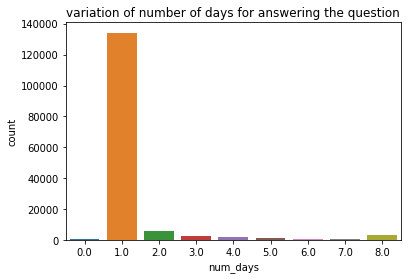

In [53]:
sns.countplot(x=df['num_days'])
plt.title('variation of number of days for answering the question')

Text(0.5, 1.0, 'variation of length of question(in words)')

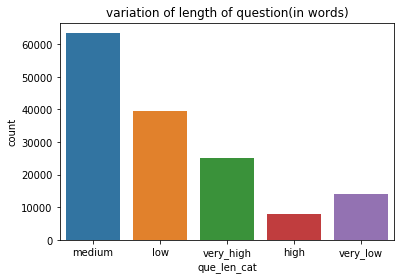

In [54]:
sns.countplot(x=df['que_len_cat'])
plt.title('variation of length of question(in words)')

Text(0.5, 1.0, 'How number of day vary with question length')

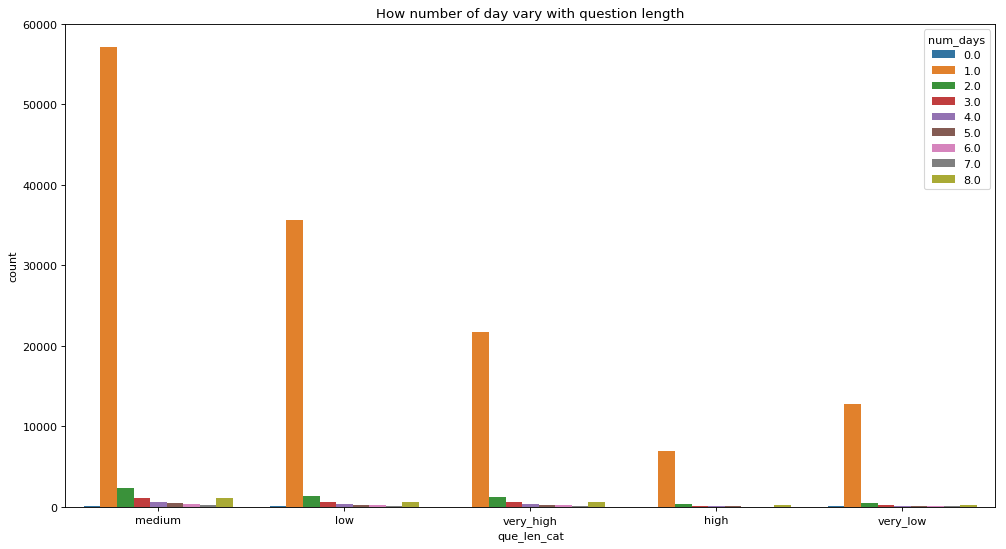

In [55]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
sns.countplot(x=df['que_len_cat'], hue=df.num_days)

plt.title('How number of day vary with question length')

# Checking how questions are answered based on tag

In [56]:

df.que_tags.iloc[1].split('|')[0]

df.que_tags.fillna(value=pd.np.nan, inplace=True)
first_tag=df.que_tags.apply(lambda x: x.split('|')[0] if pd.isnull(x)==False else np.nan)
# pd.isnull(df.que_tags.iloc[37268])
df['first_que_tag']=first_tag
print('There are total ',len(first_tag.unique()),'unique first tags.')

There are total  2778 unique first tags.


In [57]:
sum(pd.isnull(first_tag))
pd.isnull(first_tag.iloc[37268])

True

Text(0.5, 1.0, 'Number of questions answered based on tag')

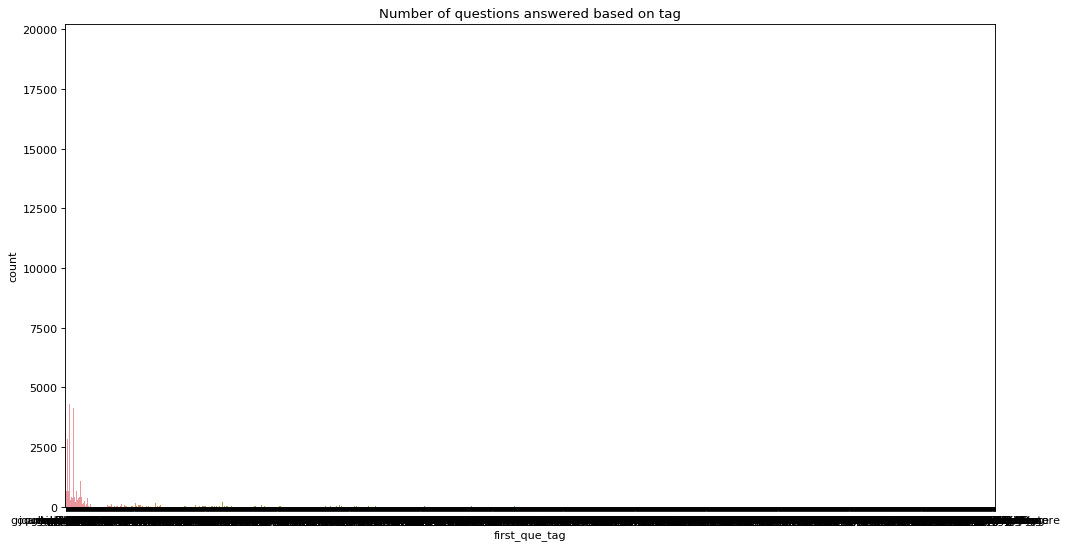

In [58]:
fig=plt.figure(figsize=(15, 8), dpi= 80, facecolor='w', edgecolor='k')
sns.countplot(x=df['first_que_tag'])

plt.title('Number of questions answered based on tag')
# gp=df.groupby(['num_days','first_que_tag'])


In [60]:
# df.groupby(['num_days','first_que_tag']).count().plot(kind='bar')
df.timediff_inDays.head()

0    0.007072
1    0.063183
2    0.182755
3    0.355752
4    0.770266
Name: timediff_inDays, dtype: float64

In [64]:
df_new=df[['ques_weekday','que_length','que_len_cat','first_que_tag','num_days']].dropna()
df_new2=df[['ques_weekday','que_length','que_len_cat','first_que_tag','label']].dropna()
df_new3=df[['ques_weekday','que_length','que_len_cat','first_que_tag','timediff_inDays']].dropna()

df_new = df_new.reset_index(drop=True)
df_new2 = df_new2.reset_index(drop=True)
df_new3 = df_new3.reset_index(drop=True)
# df_new=df_new.drop([])
print(df_new.head(3))
print(df_new2.head(3))
print(df_new3.head(3))

   ques_weekday  que_length que_len_cat first_que_tag  num_days
0           1.0       107.0      medium             r       1.0
1           6.0        98.0         low          perl       1.0
2           6.0        65.0         low          java       1.0
   ques_weekday  que_length que_len_cat first_que_tag  label
0           1.0       107.0      medium             r    1.0
1           6.0        98.0         low          perl    1.0
2           6.0        65.0         low          java    1.0
   ques_weekday  que_length que_len_cat first_que_tag  timediff_inDays
0           1.0       107.0      medium             r         0.007072
1           6.0        98.0         low          perl         0.063183
2           6.0        65.0         low          java         0.182755


# Building ML model for predicting which day of week question will be answered with df_new

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight

In [0]:
# le = preprocessing.LabelEncoder()
# le.fit(df_new.que_len_cat)
# le.transform(df_new.que_len_cat)

In [67]:
le = preprocessing.LabelEncoder()
df_new['que_len_cat'] = le.fit_transform(df_new['que_len_cat'])
df_new['first_que_tag'] = le.fit_transform(df_new['first_que_tag'])
df_new.dtypes


ques_weekday     float64
que_length       float64
que_len_cat        int64
first_que_tag      int64
num_days         float64
dtype: object

In [0]:

# random.shuffle(df_new)
X=df_new.drop('num_days',axis=1)
y=df_new.num_days

In [0]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=105,stratify=y)

 **Building SVM Classifier** 

In [0]:
# svclassifier = SVC(kernel='linear')  
# svclassifier.fit(X_train, y_train) 

**The SVM is taking  much longer time to execute leading to runtime timeout.**

**Building Logistic Regression**

Building Class weights

In [151]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
# dict(class_weights)

keys=np.unique(y_train)
w=dict(zip(keys, class_weights))
w
# np.where(y_train==0)[0][1]
# df_new.iloc[135550]
ws=df_new.num_days.value_counts()/sum(df_new.num_days.value_counts())
ws.index
ws=ws.sort_index()
print(ws)
w2=dict(zip(ws.index, 1/ws))
w2

0.0    0.002996
1.0    0.892918
2.0    0.038230
3.0    0.018127
4.0    0.010951
5.0    0.007316
6.0    0.005698
7.0    0.004746
8.0    0.019019
Name: num_days, dtype: float64


{0.0: 333.82444444444445,
 1.0: 1.1199239572072912,
 2.0: 26.157234894654362,
 3.0: 55.16746235769372,
 4.0: 91.31975683890577,
 5.0: 136.68880800727933,
 6.0: 175.49182242990656,
 7.0: 210.68863955119213,
 8.0: 52.57997899894995}

In [152]:

model = LogisticRegression(class_weight=w2)
model.fit(X_train,y_train)
y_pred_proba=model.predict_proba(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
y_pred=np.argmax(y_pred_proba,axis=1)

0.8911302523551127


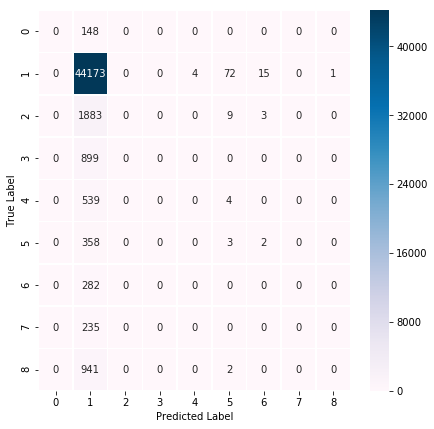

In [154]:
acc=accuracy_score(y_test,y_pred)
print(acc)
conf_mat=confusion_matrix(y_test,y_pred)
conf_mat

plt.figure(figsize=(7,7))
sns.heatmap(conf_mat,annot=True,cmap='PuBu',fmt="d",linewidths=.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Create Random Forest Model**

In [0]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
# dict(class_weights)

keys=np.unique(y_train)
w=dict(zip(keys, class_weights))
rf = RandomForestClassifier(n_estimators = 1000, random_state = 41,class_weight=w2)
rf.fit(X_train, y_train);
y_pred_rf = rf.predict(X_test)

Accuracy from Random Foest is:  0.7584975692413208


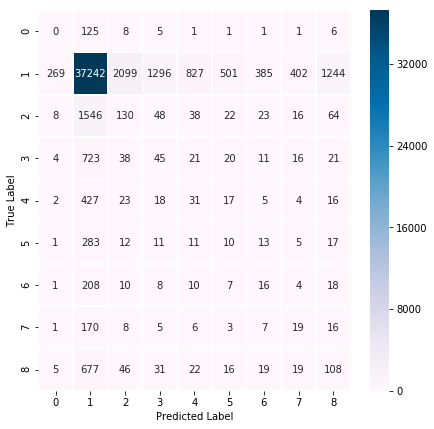

In [158]:
acc=accuracy_score(y_test,y_pred_rf)
print('Accuracy from Random Foest is: ',acc)
conf_mat=confusion_matrix(y_test,y_pred_rf)
conf_mat

plt.figure(figsize=(7,7))
sns.heatmap(conf_mat,annot=True,cmap='PuBu',fmt="d",linewidths=.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predicting with label instead of num_days using df_new2 data

In [162]:
from sklearn import preprocessing
from sklearn.metrics import classification_report
le = preprocessing.LabelEncoder()

df_new2['que_len_cat'] = le.fit_transform(df_new2['que_len_cat'])
df_new2['first_que_tag'] = le.fit_transform(df_new2['first_que_tag'])
# df_new2.first_que_tag=df_new2.first_que_tag.apply(LabelEncoder().fit_transform)
df_new2.head(5)

,ques_weekday,que_length,que_len_cat,first_que_tag,label
0,1.0,107.0,2,1996,1.0
1,6.0,98.0,1,1840,1.0
2,6.0,65.0,1,1260,1.0
3,1.0,1094.0,3,279,1.0
4,5.0,245.0,0,1272,1.0


In [0]:
X=df_new2.drop('label',axis=1)
y=df_new2.label
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=random.randint(1,100),stratify=y)

### Building Logistic Regression without class weight

In [171]:
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred_proba=model.predict_proba(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
y_pred=np.argmax(y_pred_proba,axis=1)

0.6300607185363


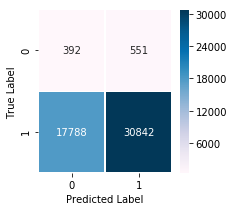

In [173]:
acc=accuracy_score(y_test,y_pred)
print(acc)
conf_mat=confusion_matrix(y_test,y_pred)
conf_mat

plt.figure(figsize=(3,3))
sns.heatmap(conf_mat,annot=True,cmap='PuBu',fmt="d",linewidths=.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Thought accuracy is very good in Logistic regression the Confusion matrix shows the actual result. This is due to high class imbalance 

**Logistic Regrssion with Class weights**

In [260]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
# dict(class_weights)

keys=np.unique(y_train)
w=dict(zip(keys, class_weights))
w
# np.where(y_train==0)[0][1]
# df_new.iloc[135550]
ws=df_new2.label.value_counts()/sum(df_new2.label.value_counts())
ws.index
ws=ws.sort_index()
print(ws)
w2=dict(zip(ws.index, 1-ws))
w2
w3 = {0: 0.979,
                1: 1-0.979}

0.0    0.019019
1.0    0.980981
Name: label, dtype: float64


In [261]:
model = LogisticRegression(class_weight=w3)
model.fit(X_train,y_train)
y_pred_proba=model.predict_proba(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
y_pred=np.argmax(y_pred_proba,axis=1)

0.8281322494099611


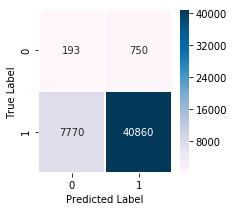

In [263]:
acc=accuracy_score(y_test,y_pred)
print(acc)
conf_mat=confusion_matrix(y_test,y_pred)
conf_mat

plt.figure(figsize=(3,3))
sns.heatmap(conf_mat,annot=True,cmap='PuBu',fmt="d",linewidths=.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Creating Random Forest model**

In [0]:
rf = RandomForestClassifier(n_estimators = 500, random_state = 412,class_weight=w)
rf.fit(X_train, y_train);
y_pred_rf = rf.predict(X_test)
y_pred_rf_prob=rf.predict_proba(X_test)


In [203]:
y_pred_rf_prob

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       ...,
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.34381089, 0.65618911]])

In [204]:
sum(y_pred_rf_prob>0.5)

array([ 1618, 47955])

0.9533818812660118
              precision    recall  f1-score   support

         0.0       0.08      0.13      0.10       943
         1.0       0.98      0.97      0.98     48630

    accuracy                           0.95     49573
   macro avg       0.53      0.55      0.54     49573
weighted avg       0.97      0.95      0.96     49573



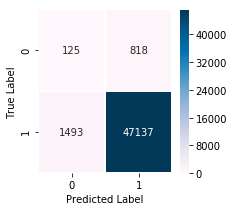

In [205]:
acc=accuracy_score(y_test,np.round(y_pred_rf))
print(acc)
print(classification_report(y_test, y_pred_rf))
conf_mat=confusion_matrix(y_test,np.round(y_pred_rf))
conf_mat

plt.figure(figsize=(2,2))
sns.heatmap(conf_mat,annot=True,cmap='PuBu',fmt="d",linewidths=.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Looks like Random Forest does a better job at classifying the results

**Running a 5 fold CV over this model**

In [0]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# kfold = KFold(n_splits=10, shuffle=True)
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)

for train_index, test_index in skf.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = RandomForestClassifier(n_estimators = 200, random_state = random.randint(1,100))
    model.fit(X_train, y_train)
    y_pred_rf = model.predict(X_test)
    acc=accuracy_score(y_test,np.round(y_pred_rf))
    print(acc)
    conf_mat=confusion_matrix(y_test,np.round(y_pred_rf))

    plt.figure(figsize=(2,2))
    sns.heatmap(conf_mat,annot=True,cmap='PuBu',fmt="d",linewidths=.5)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    

By looking at the confuion atrices  it ca b seen that maority of the low label classes are predicted as posive labels. Thiscan  improved using oersamping using SMOTE

## **Trying Boosting**

In [0]:
# from xgboost import XGBClassifier

In [0]:
# X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=141,stratify=y)
# model=XGBClassifier(learning_rate=0.05,max_depth=1)
# model.fit(X_train,y_train)


In [0]:
# y_pred_xgb = model.predict(X_test)
# y_pred_xgb

In [0]:
# acc=accuracy_score(y_test,np.round(y_pred_xgb))
# print(acc)
# conf_mat=confusion_matrix(y_test,np.round(y_pred_xgb))
# conf_mat

# plt.figure(figsize=(2,2))
# sns.heatmap(conf_mat,annot=True,cmap='PuBu',fmt="d",linewidths=.5)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

In [0]:
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.svm import SVC

In [0]:
# svc=SVC(probability=True, kernel='linear')
# rf=RandomForestClassifer(n_estimators = 500, random_state = None)
# model = AdaBoostClassifier(n_estimators=500,learning_rate=0.05,base_estimator=LogisticRegression())
# # Train Adaboost Classifer
# model.fit(X_train, y_train)

In [0]:
# y_pred_xgb = model.predict(X_test)
# y_pred_xgb

In [0]:
# acc=accuracy_score(y_test,np.round(y_pred_xgb))
# print(acc)
# conf_mat=confusion_matrix(y_test,np.round(y_pred_xgb))
# conf_mat

# plt.figure(figsize=(2,2))
# sns.heatmap(conf_mat,annot=True,cmap='PuBu',fmt="d",linewidths=.5)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

Boosting Didnt Help Much

# Using SMOTE Oversampling on df_new2 data

In [213]:
from imblearn.over_sampling import SMOTE



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [218]:

print("Data before oversampling '1': {}".format(sum(y_train==1)))
print("Data before oversampling '0': {} \n".format(sum(y_train==0)))


Data before oversampling '1': 98734
Data before oversampling '0': 1914 



In [0]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())


In [231]:
print("Data after oversampling '1': {}".format(sum(y_train_res==1)))
print("Data after oversampling '0': {} \n".format(sum(y_train_res==0)))

Data after oversampling '1': 98734
Data after oversampling '0': 98734 



### Fitting model with SMOTE over-sampled data 

In [226]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
# dict(class_weights)

keys=np.unique(y_train)
w=dict(zip(keys, class_weights))
w
# np.where(y_train==0)[0][1]
# df_new.iloc[135550]
ws=df_new2.label.value_counts()/sum(df_new2.label.value_counts())
ws.index
ws=ws.sort_index()
print(ws)
w2=dict(zip(ws.index, 1/ws))
w2

0.0    0.019019
1.0    0.980981
Name: label, dtype: float64


{0.0: 52.57997899894995, 1.0: 1.0193873673353058}

In [0]:
rf = RandomForestClassifier(n_estimators = 200, random_state = random.randint(1,100),class_weight=None)
rf.fit(X_train_res, y_train_res);
y_pred_rf = rf.predict(X_test)
y_pred_rf_prob=rf.predict_proba(X_test)


0.969640731849999
              precision    recall  f1-score   support

         0.0       0.12      0.10      0.11       943
         1.0       0.98      0.99      0.98     48630

    accuracy                           0.97     49573
   macro avg       0.55      0.54      0.55     49573
weighted avg       0.97      0.97      0.97     49573



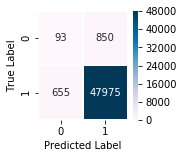

In [269]:
acc=accuracy_score(y_test,np.round(y_pred_rf))
print(acc)
print(classification_report(y_test, y_pred_rf))
conf_mat=confusion_matrix(y_test,np.round(y_pred_rf))
conf_mat

plt.figure(figsize=(2,2))
sns.heatmap(conf_mat,annot=True,cmap='PuBu',fmt="d",linewidths=.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**Doing a grid CV search to find best class weights  and n trees but leads to Runtime Timeout**

In [0]:
from sklearn.model_selection import GridSearchCV



In [0]:
# weights = np.linspace(0.05, 0.95, 20)
# n_trees=list(np.arange(50,500,10))
# gsc = GridSearchCV(
#     estimator=RandomForestClassifier(),
#     param_grid={
#         'class_weight': [{0: x, 1: 1.0-x} for x in weights],
#         'n_estimators':n_trees
#     },
#     scoring='f1',
#     cv=3
# )
# grid_result = gsc.fit(X_train, y_train)

# print("Best parameters : %s" % grid_result.best_params_)

# # Plot the weights vs f1 score
# dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
#                        'weight': weights,'n_trees':ntrees })
# dataz.plot(x='weight')
# dataz.plot(x='n_trees')

**Running a 5 fold CV over the smote model**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.965377369956247


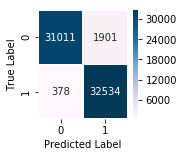

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


KeyboardInterrupt: ignored

In [283]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# kfold = KFold(n_splits=10, shuffle=True)
X_train_df=pd.DataFrame(X_train_res)
y_train_df=pd.DataFrame(y_train_res)
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_train_df, y_train_df)

for train_index, test_index in skf.split(X_train_df, y_train_df):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_CV, X_test_CV = X_train_df.iloc[train_index], X_train_df.iloc[test_index]
    y_train_CV, y_test_CV = y_train_df.iloc[train_index], y_train_df.iloc[test_index]
    model = RandomForestClassifier(n_estimators = 200, random_state = random.randint(1,100))
    model.fit(X_train_CV, y_train_CV)
    y_pred_rf = model.predict(X_test_CV)
    y_pred_rf_prob = model.predict_proba(X_test_CV)
    acc=accuracy_score(y_test_CV,y_pred_rf)
    print(acc)
    conf_mat=confusion_matrix(y_test_CV,y_pred_rf)

    plt.figure(figsize=(2,2))
    sns.heatmap(conf_mat,annot=True,cmap='PuBu',fmt="d",linewidths=.5)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    

**Final Model**

In [284]:
rf = RandomForestClassifier(n_estimators = 200, random_state = random.randint(1,100),class_weight=None)
rf.fit(X_train_df, y_train_df);
y_pred_rf = rf.predict(X_test)
y_pred_rf_prob=rf.predict_proba(X_test)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.969640731849999
              precision    recall  f1-score   support

         0.0       0.12      0.10      0.11       943
         1.0       0.98      0.99      0.98     48630

    accuracy                           0.97     49573
   macro avg       0.55      0.54      0.55     49573
weighted avg       0.97      0.97      0.97     49573



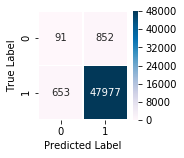

In [285]:
acc=accuracy_score(y_test,np.round(y_pred_rf))
print(acc)
print(classification_report(y_test, y_pred_rf))
conf_mat=confusion_matrix(y_test,np.round(y_pred_rf))
conf_mat

plt.figure(figsize=(2,2))
sns.heatmap(conf_mat,annot=True,cmap='PuBu',fmt="d",linewidths=.5)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [287]:
print('Probabilities either question will be answered before or after 7 days:')
y_pred_rf_prob

Probabilities either question will be answered before or after 7 days:


array([[0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       ...,
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.58, 0.42]])